In [1]:
import numpy as np
import matplotlib.pyplot as plt
import george
from george import kernels
%matplotlib inline
from astropy.table import Table
from george.modeling import Model
import pymc3 as pm
import seaborn as sns
sns.set_context("talk")
sns.set_style("white")
sns.set_palette("Dark2")


In [2]:
tab = Table.read('Data/SN1987A_photometry.csv',format='ascii')
band = tab['band']
time = tab['time']
mag = tab['magnitude']
band_name = np.unique(band)
tab

event,time,magnitude,e_magnitude,upperlimit,band,instrument,telescope,source
str7,float64,float64,int64,int64,str1,int64,int64,str104
SN1987A,46849.44,6.36,--,--,V,--,--,"1987IAUC.4495....1M,Sternberg Astronomical Institute Supernova Light Curve Catalogue"
SN1987A,46849.62,6.11,--,--,V,--,--,"1987IAUC.4495....1M,Sternberg Astronomical Institute Supernova Light Curve Catalogue"
SN1987A,46850.45,4.89,--,--,B,--,--,"1987IAUC.4313....1M,Sternberg Astronomical Institute Supernova Light Curve Catalogue"
SN1987A,46850.45,4.06,--,--,U,--,--,"1987IAUC.4313....1M,Sternberg Astronomical Institute Supernova Light Curve Catalogue"
SN1987A,46850.45,4.81,--,--,V,--,--,"1987IAUC.4313....1M,Sternberg Astronomical Institute Supernova Light Curve Catalogue"
SN1987A,46850.8,4.74,--,--,B,--,--,"1987IAUC.4320....1F,Sternberg Astronomical Institute Supernova Light Curve Catalogue"
SN1987A,46850.8,4.29,--,--,I,--,--,"1987IAUC.4320....1F,Sternberg Astronomical Institute Supernova Light Curve Catalogue"
SN1987A,46850.8,4.37,--,--,R,--,--,"1987IAUC.4320....1F,Sternberg Astronomical Institute Supernova Light Curve Catalogue"
SN1987A,46850.8,3.95,--,--,U,--,--,"1987IAUC.4320....1F,Sternberg Astronomical Institute Supernova Light Curve Catalogue"


findfont: Font family ['Cambria'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Cambria'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Cambria'] not found. Falling back to DejaVu Sans.


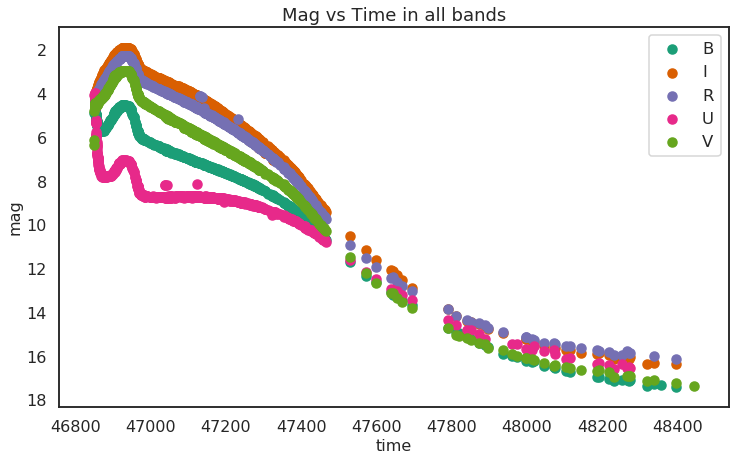

In [3]:

plt.figure(figsize = (12,7))
for i in range(len(band_name)):
    plt.scatter(time[band == band_name[i]], mag[band == band_name[i]], label = str(band_name[i]))
    plt.legend()
plt.title("Mag vs Time in all bands")
plt.xlabel("time") 
plt.ylabel("mag")
plt.gca().invert_yaxis()

In [4]:
mask = (time>46800) & (time < 47200)
mtab = tab[mask]
mtime = mtab['time']
mmag = mtab['magnitude']
mband = mtab['band']
min_time = np.min(mtime)
mtime = mtime - min_time # to make time start from zero

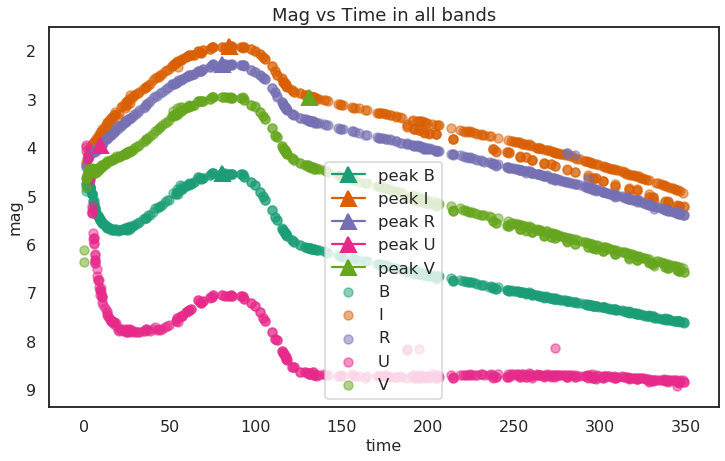

In [5]:
plt.figure(figsize = (12,7))
for i in range(len(band_name)):
    plt.scatter(mtime[mband == band_name[i]], mmag[mband == band_name[i]], label = str(band_name[i]), alpha = 0.5)
    #min_index = np.argmin(mmag[mband == band_name[i]])
    min_mag = np.min(mmag[mband == band_name[i]])
    plt.plot(np.median(mtime[mmag == min_mag]), min_mag , marker ='^', label = 'peak ' + str(band_name[i]), ms=15.,  mew=2)
    plt.legend(loc = 'best')
plt.title("Mag vs Time in all bands")
plt.xlabel("time") 
plt.ylabel("mag")
plt.gca().invert_yaxis()


In [6]:
class mean_model(Model):
    parameter_names = ("a1", "b1", "c1","a2", "b2", "c2" )
    
    def get_value(self, t):
        magnitude = []
        for x in t:
            if x < 115:
                magnitude.append(self.a1*x**2 + self.b1*x + self.c1)
            else:
                magnitude.append(self.a2*x**2 + self.b2*x + self.c2)
        return np.array(magnitude)

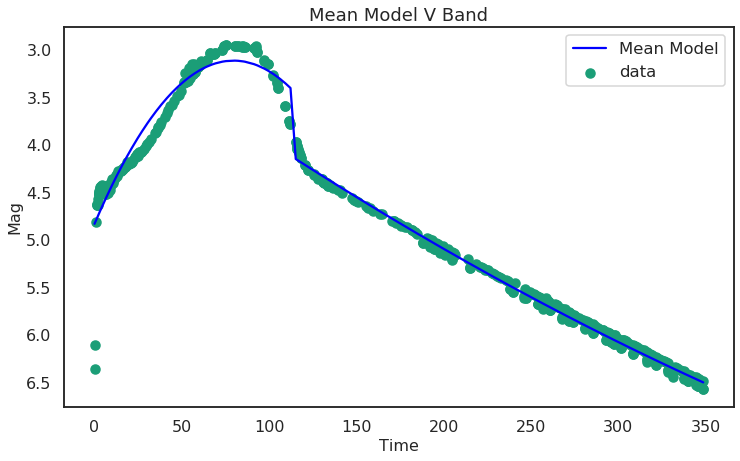

In [7]:
v_mtime = np.asarray(mtime[mband == 'V'])
v_mmag =  np.asarray(mmag[mband == 'V'])
A1,B1,C1 = np.polyfit(v_mtime[v_mtime<115], v_mmag[v_mtime<115], 2)
A2,B2,C2  = np.polyfit(v_mtime[v_mtime>115], v_mmag[v_mtime>115], 2)
model_flux = mean_model(a1=A1, b1= B1, c1=C1, a2=A2, b2=B2, c2=C2).get_value(v_mtime)

#plot the model on top of the original data  
plt.figure(figsize=(12,7))
plt.scatter(v_mtime, v_mmag, label = "data")
plt.plot(v_mtime, model_flux,'b-', label = "Mean Model")
plt.title('Mean Model V Band')
plt.xlabel("Time")
plt.ylabel("Mag")
plt.legend(loc='best')
plt.gca().invert_yaxis()

[ 2.71116252e-04 -4.31769322e-02  4.83143624e+00 -7.30072808e-06
  1.34684156e-02  2.69319695e+00  4.24849524e+00]


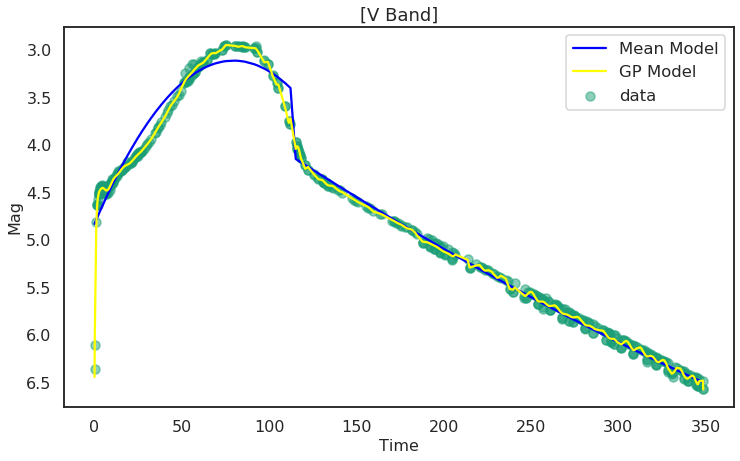

In [8]:
MEAN = mean_model(a1=A1, b1= B1, c1=C1, a2=A2, b2=B2, c2=C2)
k = kernels.ExpSquaredKernel(70.0)

gp = george.GP(k, mean = MEAN)
gp.compute(v_mtime)

print(gp.get_parameter_vector())

mu,var = gp.predict(v_mmag,v_mtime,return_var=True)

plt.figure(figsize=(12,7))
plt.scatter(v_mtime, v_mmag, label = "data", alpha = 0.5)
plt.plot(v_mtime, model_flux,'b-', label = "Mean Model")
plt.plot(v_mtime, mu, color="yellow", label = 'GP Model ')
plt.title('[V Band]')
plt.xlabel("Time")
plt.ylabel("Mag")
plt.legend(loc='best')
plt.gca().invert_yaxis()



In [9]:
#The mean function is the same as before but its rewritten in a format that is acceptable by the gp.marginal function
import theano.tensor as tt
import pymc3 as pm

class MeanModel(pm.gp.mean.Mean):

    def __init__(self, a1,b1,c1,a2,b2,c2):
        self.a1 = a1
        self.b1 = b1
        self.c1 = c1
        self.a2 = a2
        self.b2 = b2
        self.c2 = c2
        
    def __call__(self, t):
        t = np.array(t)
        peak_t = 115
        rise_t = t[t <= peak_t]
        fall_t = t[t > peak_t]
        rise_mag = self.a1*rise_t**2 + self.b1*rise_t + self.c1
        fall_mag = self.a1*fall_t**2 + self.b1*fall_t + self.c1
        mean_mag = tt.concatenate([rise_mag, fall_mag])
        return mean_mag


In [10]:
X =v_mtime[:,None]
Y = v_mmag


In [11]:
with pm.Model() as marginal_gp_model:
    # Specify the covariance function.
    cov_func = pm.gp.cov.ExpQuad(input_dim=1, ls=50)
    
    aa1 = pm.Normal('aa1', mu=A1, sigma=A1*1e-1, shape=1)
    bb1 = pm.Normal('bb1', mu=B1, sigma=B1*1e-1, shape=1)
    cc1 = pm.Normal('cc1', mu=C1, sigma=C1*1e-1, shape=1)
    aa2 = pm.Normal('aa2', mu=A2, sigma=A2*1e-1, shape=1)
    bb2 = pm.Normal('bb2', mu=B2, sigma=B2*1e-1, shape=1)
    cc2 = pm.Normal('cc2', mu=C2, sigma=C2*1e-1, shape=1)
    
    
    # Specify the GP
    MEAN = MeanModel(a1=aa1, b1= bb1, c1=cc1, a2=aa2, b2=bb2, c2=cc2)
    gp = pm.gp.Marginal(cov_func=cov_func, mean_func = MEAN)

    # The scale of the white noise term can be provided,
    sigma = pm.HalfCauchy("sigma", beta=0.75)
    y_ = gp.marginal_likelihood("y", X=X, y=Y, noise=sigma)
    MAP =  pm.find_MAP()

/Users/charmipatel/anaconda3/envs/fds/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/charmipatel/anaconda3/envs/fds/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
/Users/charmipatel/anaconda3/envs/fds/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use

In [12]:
X_new = np.linspace(0, np.max(X),len(X))[:,None]

# add the GP conditional to the model, given the new X values
with marginal_gp_model:
    f_pred = gp.conditional("f_pred", X_new)

#To use the MAP values, you can just replace the trace with a length-1 list with `mp`

with marginal_gp_model:
    pred_samples = pm.sample_posterior_predictive([MAP], vars=[f_pred],samples=50)

/Users/charmipatel/anaconda3/envs/fds/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
  0%|          | 0/50 [00:00<?, ?it/s]/Users/charmipatel/anaconda3/envs/fds/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/charmipatel/anaconda3/envs/fds/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is 

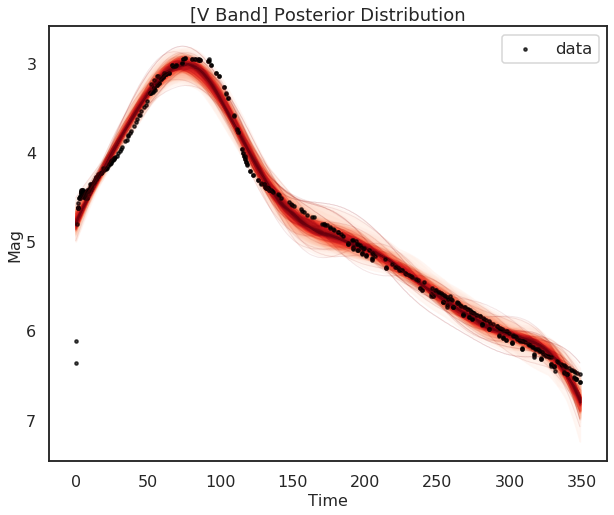

In [13]:
from pymc3.gp.util import plot_gp_dist
# plot the results
fig = plt.figure(figsize=(10,8))
ax = fig.gca()
plot_gp_dist(ax, pred_samples["f_pred"], X_new)
plt.scatter(v_mtime, v_mmag,s =10, label = "data",alpha = 0.7, color = "black")
plt.title('[V Band] Posterior Distribution')
plt.xlabel("Time")
plt.ylabel("Mag")
plt.legend(loc='best')
plt.gca().invert_yaxis()

In [14]:
d = {} 
for i in band_name:
    d[i+'_mtime'] = np.asarray(mtime[mband == i])
    d[i+'_mmag'] =  np.asarray(mmag[mband == i])
    A1,B1,C1 = np.polyfit(d[i+'_mtime'][d[i+'_mtime']<115], d[i+'_mmag'][d[i+'_mtime']<115], 2)
    A2,B2,C2 = np.polyfit(d[i+'_mtime'][d[i+'_mtime']<115], d[i+'_mmag'][d[i+'_mtime']<115], 2)
    d[i+'_params'] = np.array([A1,B1,C1,A2,B2,C2])
    d[i+'_X'] = d[i+'_mtime'][:,None]
    

/Users/charmipatel/anaconda3/envs/fds/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/charmipatel/anaconda3/envs/fds/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
/Users/charmipatel/anaconda3/envs/fds/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use

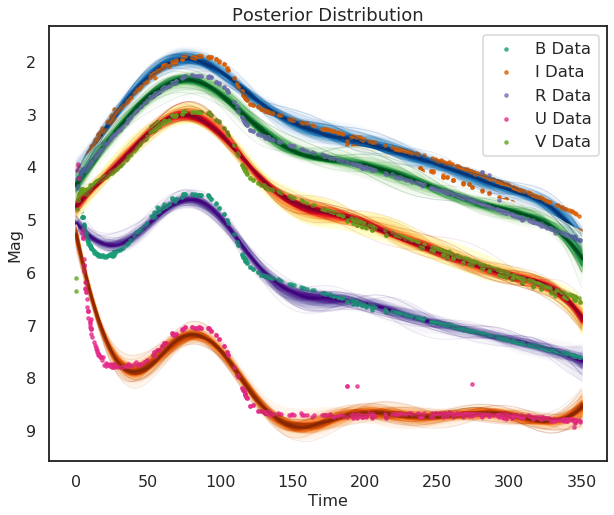

In [15]:
fig = plt.figure(figsize=(10,8))
ax = fig.gca()
color = ['Purples', 'Blues', 'Greens', 'Oranges', 'YlOrRd']
X_new = np.linspace(0, 350,200)[:,None]

for x in range(len(band_name)):
    i = band_name[x]
    with pm.Model() as hierarchical_model: 
        cov_func = pm.gp.cov.ExpQuad(input_dim=1, ls=50)

        p = d[i+'_params']
        A1,B1,C1,A2,B2,C2 = p[0],p[1],p[2],p[3],p[4],p[5]
        aa1 = pm.Normal('aa1', mu=A1, sigma=A1*1e-1, shape=1)
        bb1 = pm.Normal('bb1', mu=B1, sigma=B1*1e-1, shape=1)
        cc1 = pm.Normal('cc1', mu=C1, sigma=C1*1e-1, shape=1)
        aa2 = pm.Normal('aa2', mu=A2, sigma=A2*1e-1, shape=1)
        bb2 = pm.Normal('bb2', mu=B2, sigma=B2*1e-1, shape=1)
        cc2 = pm.Normal('cc2', mu=C2, sigma=C2*1e-1, shape=1)


        MEAN = MeanModel(a1=aa1, b1= bb1, c1=cc1, a2=aa2, b2=bb2, c2=cc2)
        gp = pm.gp.Marginal(cov_func=cov_func, mean_func = MEAN)
        sigma = pm.HalfCauchy("sigma", beta=0.75)
        y_ = gp.marginal_likelihood("y", X=d[i+'_X'], y=d[i+'_mmag'], noise=sigma)
        MAP =  pm.find_MAP()
        
    with marginal_gp_model:
        d[i+'_fpred'] = gp.conditional(i+'_fpred', X_new)

    with marginal_gp_model:
        d[i+'_pred_samples'] = pm.sample_posterior_predictive([MAP], vars=[d[i+'_fpred']],samples=50)
    
    plot_gp_dist(ax, d[i+'_pred_samples'][i+'_fpred'], X_new, palette = color[x])
    plt.scatter(d[i+'_mtime'], d[i+'_mmag'] ,s =10, label = i+" Data",alpha = 0.7, cmap = color[x])

plt.title('Posterior Distribution')
plt.xlabel("Time")
plt.ylabel("Mag")
plt.legend(loc='best')
plt.gca().invert_yaxis()

In [16]:
median = np.median(d['V_pred_samples']['V_fpred'], axis=0)
print(np.shape(median))
print(np.shape(X_new.T))

(200,)
(1, 200)


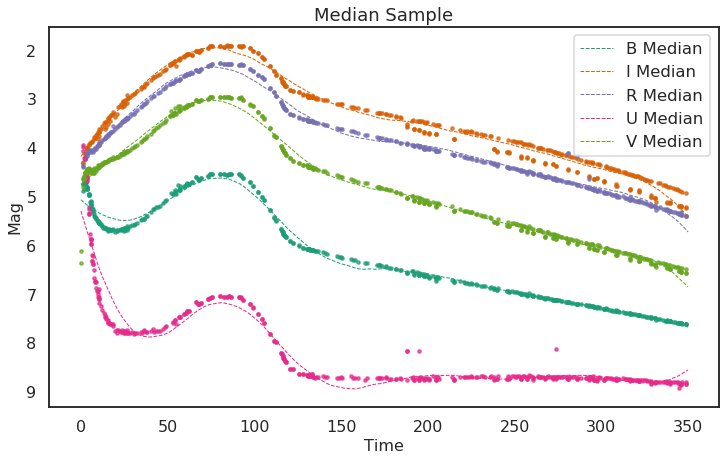

In [17]:
fig = plt.figure(figsize=(12,7))
ax = fig.gca()
X_new = np.linspace(0, 350,200)
for x in range(len(band_name)):
    i = band_name[x]
    d[i+"_med"] = np.median(d[i+'_pred_samples'][i+'_fpred'], axis=0)
    plt.plot(X_new, d[i+"_med"], ls = '--', linewidth= 1 ,label = i+" Median")
    plt.scatter(d[i+'_mtime'], d[i+'_mmag'] ,s =10,alpha = 0.7)

plt.title('Median Sample')
plt.xlabel("Time")
plt.ylabel("Mag")
plt.legend(loc='best')
plt.gca().invert_yaxis()

In [18]:
def convert_mag_to_flux(mag, fo):
    return fo* 10**(-mag/2.5)




In [20]:
wavelengths = (np.array([435,  879.7,  634.9,365.6, 547.7])*10)
lamda = wavelengths[np.argsort(wavelengths)] #in  A˚ 
X_new = np.linspace(0, 350,200)
f_L = (np.array([632,112.6,217.7,417.5, 363.1])*(1e-11))[np.argsort(wavelengths)] #ergs/(cm^2 * s * A˚)
band_name = band_name[np.argsort(wavelengths)]

F_bol = []
for i in range(len(X_new)):
    flux = [(convert_mag_to_flux(d[band_name[n]+"_med"][i],f_L[n])) for n in range(5)]
    F_bol.append(np.trapz(flux,lamda))

Text(0, 0.5, '$F_{Bol}$ (ergs cm$^{-2}$ s$^{-1}$)')

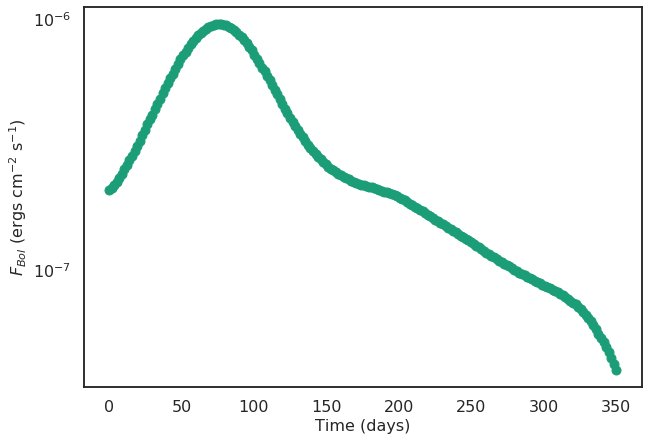

In [21]:
fig = plt.figure(figsize=(10,7)); 
ax = fig.gca()

plt.semilogy(X_new, np.array(F_bol), 'o-')
plt.xlabel("Time (days)");
plt.ylabel(r"$F_{Bol}$ (ergs cm$^{-2}$ s$^{-1}$)")

Text(0, 0.5, '$L_{Bol}$ (ergs/s)')

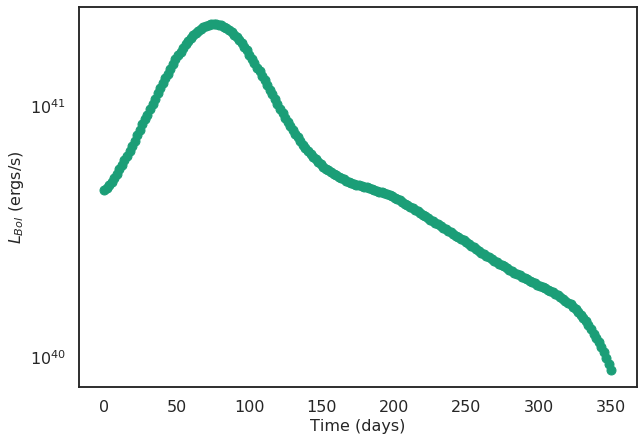

In [22]:
r = 0.043*3.086e24 #cm

def convert_flux_to_luminosity(flux, r):
    return 4*np.pi* (r**2) * flux
L_bol = convert_flux_to_luminosity(np.array(F_bol),r)

fig = plt.figure(figsize=(10,7)); 
ax = fig.gca()

plt.semilogy(X_new, np.array(L_bol), 'o-')
plt.xlabel("Time (days)");
plt.ylabel(r"$L_{Bol}$ (ergs/s)")   

Text(0, 0.5, 'Temp(K)')

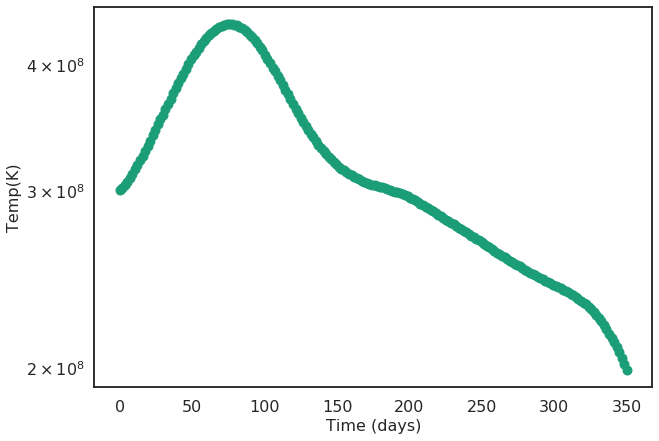

In [24]:
L_bol = np.array(L_bol) *1.e-7 # SI units
sigma = 5.670374419e-8 #W⋅m−2⋅K−4

def convert_luminosity_to_temp(lum,sigma):
    return (lum/sigma)**(1./4) # Kelvin

temp = convert_luminosity_to_temp(L_bol,sigma)

fig = plt.figure(figsize=(10,7)); 
ax = fig.gca()

plt.semilogy(X_new, temp, 'o-')
plt.xlabel("Time (days)");
plt.ylabel(r"Temp(K)")   